# Introduction to Dask cuDF

[Dask](https://dask.org/) cuDF can be used to distribute dataframe operations to multiple GPUs. In this notebook we will introduce some key Dask concepts, learn how to setup a Dask cluster for utilizing multiple GPUs, and see how to perform simple dataframe operations on distributed Dask dataframes.

## Objectives

By the time you complete this notebook you will be able to:

- Create a Dask GPU Cluster
- Create and execute Dask cuDF dataframe computational graphs on multiple GPUs

## An Introduction to Dask

[Dask](https://dask.org/) is a Python library for parallel computing. In Dask programming, we create computational graphs that define code we **would like** to execute, and then, give these computational graphs to a Dask scheduler which evaluates them lazily, and efficiently, in parallel. 

In addition to using multiple CPU cores or threads to execute computational graphs in parallel, Dask schedulers can also be configured to execute computational graphs on multiple CPUs, or, as we will do in this workshop, multiple GPUs. As a result, Dask programming facilitates operating on datasets that are larger than the memory of a single compute resource.

Because Dask computational graphs can consist of arbitrary Python code, they provide [a level of control and flexiblility superior to many other systems](https://docs.dask.org/en/latest/spark.html) that can operate on massive datasets. However, we will focus for this workshop primarily on the Dask DataFrame, one of several data structures whose operations and methods natively utilize Dask's parallel scheduling:

- Dask DataFrame, which closely resembles the Pandas DataFrame
- Dask Array, which closely resembles the NumPy ndarray
- Dask Bag, a set which allows duplicates and can hold heterogenously-typed data

In particularly, we will use a Dask-cuDF dataframe, which combines the interface of Dask with the GPU power of cuDF for distributed dataframe operations on multiple GPUs. We will now turn our attention to utilizing all 4 NVIDIA V100 GPUs in this environment for operations on an 18GB UK population dataset that would not fit into the memory of a single 16GB GPU.

## Setting up a Dask Scheduler

We begin by starting a Dask scheduler which will take care to distribute our work across the 4 available GPUs. In order to do this we need to start a `LocalCUDACluster` instance, using our host machine's IP, and then instantiate a client that can communicate with the cluster.

### Obtaining the Local IP Address

In [5]:
import subprocess # we will use this to obtain our local IP using the following command
cmd = "hostname --all-ip-addresses"

process = subprocess.Popen(cmd.split(), stdout=subprocess.PIPE)
output, error = process.communicate()
IPADDR = str(output.decode()).split()[0]

### Starting a `LocalCUDACluster`

`dask_cuda` provides utilities for Dask and CUDA (the "cu" in cuDF) interactions.

In [6]:
from dask_cuda import LocalCUDACluster
cluster = LocalCUDACluster(ip=IPADDR)

/opt/conda/envs/rapids/lib/python3.7/site-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 33456 instead
  http_address["port"], self.http_server.port


### Instantiating a Client Connection

The `dask.distributed` library gives us distributed functionality, including the ability to connect to the CUDA Cluster we just created. The `progress` import will give us a handy progress bar we can utilize below.

In [8]:
from dask.distributed import Client, progress

client = Client(cluster)

### The Dask Dashboard

Dask ships with a very helpful dashboard that in our case runs on port `8787`. Open a new browser tab now and copy this lab's URL into it, replacing `/lab/lab` with `:8787` (so it ends with `.com:8787`). This should open the Dask dashboard, currently idle.

## Reading Data with Dask cuDF

With `dask_cudf` we can create a dataframe from several file formats (including from multiple files and directly from cloud storage like S3), from cuDF dataframes, from Pandas dataframes, and even from vanilla CPU Dask dataframes. Here we will create a Dask cuDF dataframe from the local csv file `pop5x_1-07.csv`, which has similar features to the `pop.csv` files you have already been using, except scaled up to 5 times larger (18GB), representing a population of almost 300 million, nearly the size of the entire United States.

In [9]:
# get the file size of `pop5x_1-07.csv` in GB
!ls -sh data/pop5x_1-07.csv

18G data/pop5x_1-07.csv


We import dask_cudf (and other RAPIDS components when necessary) after setting up the cluster to ensure that they establish correctly inside the CUDA context it creates.

In [10]:
import dask_cudf

In [11]:
ddf = dask_cudf.read_csv('./data/pop5x_1-07.csv', dtype=['float32', 'str', 'str', 'float32', 'float32', 'str'])

In [12]:
ddf.dtypes


age       float32
sex        object
county     object
lat       float32
long      float32
name       object
dtype: object

As mentioned above, when programming with Dask, we create computational graphs that we **would eventually like** to be executed. We can already observe this behavior in action: in calling `dask_cudf.read_csv` we have indicated that **would eventually like** to read the entire contents of `pop5x_1-07.csv`. However, Dask will not ask the scheduler execute this work until we explicitly indicate that we would like it do so.

Observe the memory usage for each of the 4 GPUs by executing the following cell, and notice that the GPU memory usage is not nearly large enough to indicate that the entire 18GB file has been read into memory:

In [13]:
!nvidia-smi

Thu Jan 14 21:33:28 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 440.33.01    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:1B.0 Off |                    0 |
| N/A   43C    P0    52W / 300W |   1930MiB / 16160MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  Off  | 00000000:00:1C.0 Off |                    0 |
| N/A   46C    P0    53W / 300W |   1231MiB / 16160MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

## Visualizing the Computational Graph

Computational graphs that have not yet been executed provide the `.visualize` method that, when used in a Jupyter environment such as this one, will display the computational graph, including how Dask intends to go about distributing the work. Thus, we can visualize how the `read_csv` operation will be distributed by Dask by executing the following cell:

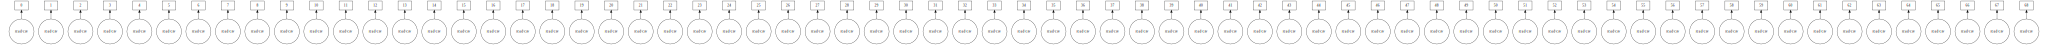

In [14]:
ddf.visualize(format='svg') # This visualization is very large, and using `format='svg'` will make it easier to view.

As you can see, when we indicate for Dask to actually execute this operation, it will parallelize the work across the 4 GPUs in something like 69 parallel partitions. We can see the exact number of partitions with the `npartitions` property:

In [15]:
ddf.npartitions

69

## Extending the Computational Graph

The concept of constructing computational graphs with arbitrary operations before executing them is a core part of Dask. Let's add some operations to the existing computational graph and visualize it again.

After running the next cell, although it will take some scrolling to get a clear sense of it (the challenges of distributed data analytics!), you can see that the graph already constructed for `read_csv` now continues upward. It selects the `age` column across all partitions (visualized as `getitem`) and eventually performs the `.mean()` reduction (visualized as `series-sum-chunk`, `series-sum-agg`, `count-chunk`, `sum-agg` and `true-div`).

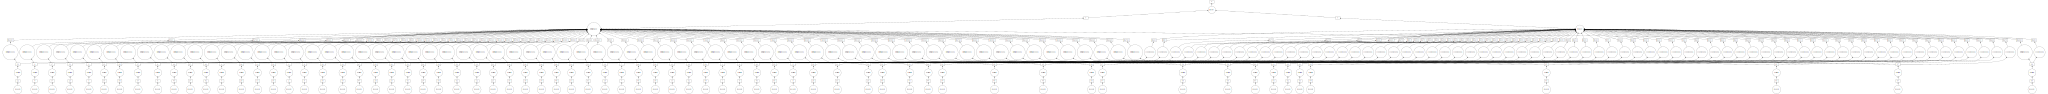

In [16]:
mean_age = ddf['age'].mean()
mean_age.visualize(format='svg')

## Computing with the Computational Graph

There are several ways to indicate to Dask that we would like to perform the computations described in the computational graphs we have constructed. The first we will show is the `.compute` method, which will return the output of the computation as an object in one GPU's memory - no longer distributed across GPUs.

(**NOTE**: This value is actually a [*future*](https://docs.python.org/3/library/concurrent.futures.html) that it can be immediately used in code, even before it completes evaluating. While this can be tremendously useful in many scenarios, we will not need in this workshop to do anything fancy with the futures we generate except to wait for them to evaluate so we can visualize their values).

Execute the following cell to send the computational graph we have created to the Dask scheduler to be executed in parallel on our 4 GPUs. If you have the Dask Dashboard open on another tab from before, you can watch it while the operation completes. Because our graph involves reading the entire 18GB dataset (as we declared when adding `read_csv` to the call graph), you can expect the operation to take a little time. If you closely watch the dashboard, you will see that Dask begins follow-on calculations for `mean` even while data is still being read into memory.

In [18]:
mean_age.compute()

40.12419408626151

### Persisting Data in the Cluster

As you can see, the previous operation, which read the entire 18GB csv into the GPUs' memory, did not retain the data in memory after completing the computational graph:

In [19]:
!nvidia-smi

Thu Jan 14 21:40:54 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 440.33.01    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:1B.0 Off |                    0 |
| N/A   44C    P0    52W / 300W |   2322MiB / 16160MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  Off  | 00000000:00:1C.0 Off |                    0 |
| N/A   47C    P0    53W / 300W |   1623MiB / 16160MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

A typical Dask workflow, which we will utilize, is to persist data we would like to work with to the cluster and then perform fast operations on that persisted data. We do this with the `.persist` method. From the [Dask documentation](https://distributed.dask.org/en/latest/manage-computation.html#client-persist):

>The `.persist` method submits the task graph behind the Dask collection to the scheduler, obtaining Futures for all of the top-most tasks (for example one Future for each Pandas [*or cuDF*] DataFrame in a Dask[*-cudf*] DataFrame). It then returns a copy of the collection pointing to these futures instead of the previous graph. This new collection is semantically equivalent but now points to actively running data rather than a lazy graph.

Here we persist `ddf` to the cluster so that it will reside in GPU memory for us to perform fast operations on:

In [20]:
ddf = ddf.persist()

As you can see by executing `nvidia-smi` (after letting the `persist` finish), each GPU now has parts of the distributed dataframe in its memory, expanded to about 32GB in memory from 18GB on disk:

In [21]:
!nvidia-smi

Thu Jan 14 21:42:52 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 440.33.01    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:1B.0 Off |                    0 |
| N/A   44C    P0    52W / 300W |   5396MiB / 16160MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  Off  | 00000000:00:1C.0 Off |                    0 |
| N/A   47C    P0    53W / 300W |   4699MiB / 16160MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

Running `ddf.visualize` now shows that we no longer have operations in our task graph, only partitions of data, ready for us to perform operations:

In [22]:
ddf.visualize(format='svg')

Computing operations on this data will now be much faster:

In [23]:
ddf['age'].mean().compute()

40.12419408626151

## Initial Data Exploration with Dask cuDF

The beauty of Dask is that working with your data, even though it is distributed and massive, is a lot like working with smaller in-memory datasets.

In [24]:
ddf.head() # As a convenience, no need to `.compute` the `head()` method

,age,sex,county,lat,long,name
0,0.0,m,Darlington,54.549641,-1.493884,HARRISON
1,0.0,m,Darlington,54.523945,-1.401142,LAKSH
2,0.0,m,Darlington,54.561127,-1.690068,MUHAMMAD
3,0.0,m,Darlington,54.542988,-1.543216,GRAYSON
4,0.0,m,Darlington,54.532101,-1.569116,FINLAY


In [25]:
ddf.count().compute()

age       292399470
sex       292399470
county    292399470
lat       292399470
long      292399470
name      292399470
dtype: int64

In [26]:
ddf.dtypes

age       float32
sex        object
county     object
lat       float32
long      float32
name       object
dtype: object

## Exercise: Counties North of Sunderland with Dask

Here we ask you to revisit an earlier exercise, but on the distributed dataset. Hopefully, it's clear how similar the code is for single-GPU dataframes and distributed dataframes with Dask.

Identify the latitude of the northernmost resident of Sunderland county (the person with the maximum `lat` value), and then determine which counties have any residents north of this resident. Use the `unique` method of a cudf `Series` to deduplicate the result.

In [37]:
nSud = ddf.loc[ddf["county"] == "Sunderland"]
maxLat = nSud["lat"].max()
north= ddf.loc[ddf["lat"] > maxLat]
res = north["county"].unique()
res.compute()
res.head()

0          County Durham
1                Cumbria
2              Gateshead
3    Newcastle upon Tyne
4         North Tyneside
Name: county, dtype: object

#### Solution

In [28]:
# %load solutions/counties_north_of_sunderland_ddf
sunderland_residents = ddf.loc[ddf['county'] == 'Sunderland']
northmost_sunderland_lat = sunderland_residents['lat'].max()
counties_with_pop_north_of = ddf.loc[ddf['lat'] > northmost_sunderland_lat]['county'].unique()
counties_with_pop_north_of.compute()
counties_with_pop_north_of.head()


0          County Durham
1                Cumbria
2              Gateshead
3    Newcastle upon Tyne
4         North Tyneside
Name: county, dtype: object

<br>
<div align="center"><h2>Please Restart the Kernel</h2></div>

In [38]:
import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker


## Next

With this introduction to Dask cuDF, you will now proceed in the next notebook to do more advanced data transformation with Dask, revisting the grid coordinate converter function, but applying it to the 18GB 5x UK population dataset.